In [1]:
import pandas as pd
import numpy as np
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
SCRIPT_DIR = (os.path.dirname(os.path.realpath("__file__")))
DATA_DIR = os.path.join(os.path.dirname(SCRIPT_DIR), "data")

In [3]:
train = pd.read_csv(f"{DATA_DIR}/train_E1GspfA.csv")
test = pd.read_csv(f"{DATA_DIR}/test_6QvDdzb.csv")

print(train.shape, test.shape)

(18247, 3) (7650, 2)


In [4]:
train.sample()

,date,hour,demand
8750,2019-11-11,11,181


In [5]:
test.sample()

,date,hour
90,2021-03-05,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18247 entries, 0 to 18246
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    18247 non-null  object
 1   hour    18247 non-null  int64 
 2   demand  18247 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 427.8+ KB


In [7]:
train['datetime'] = pd.to_datetime(train['date'] + " " + train['hour'].astype(str) + ":00:00", errors="coerce")
test['datetime'] = pd.to_datetime(test['date'] + " " + test['hour'].astype(str) + ":00:00", errors="coerce")

train = train[['datetime', 'demand']]
test = test[['datetime']]

In [8]:
train.sample()

,datetime,demand
11541,2020-03-22 21:00:00,71


In [9]:
test.sample()

,datetime
6596,2022-02-07 05:00:00


In [10]:
tmp = train.copy()
tmp['date'] = tmp['datetime'].dt.date
tmp = pd.pivot_table(
    tmp,
    index=['date'],
    values=['demand'],
    aggfunc=np.sum
)

In [11]:
# plt.figure(figsize=(20,10))
# sns.lineplot(data=train, x='datetime', y='demand')

In [12]:
import dtale

dtale.show(train)

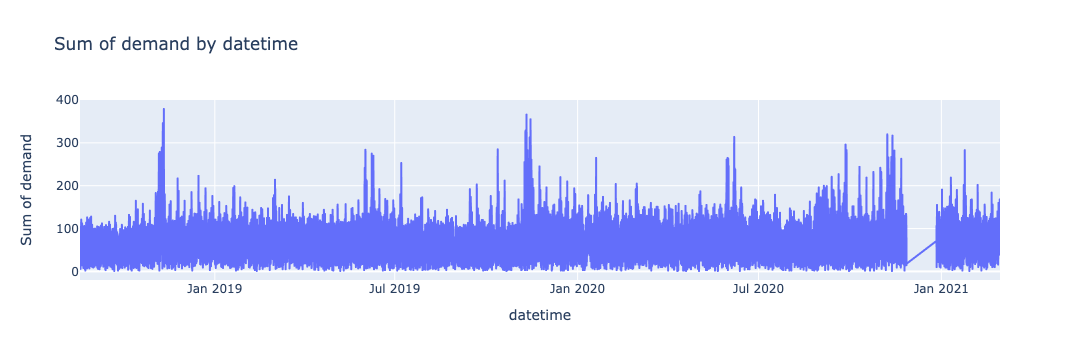

In [13]:
# DISCLAIMER: 'train' refers to the data you passed in when calling 'dtale.show'

import pandas as pd

if isinstance(train, (pd.DatetimeIndex, pd.MultiIndex)):
	train = train.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
train = train.reset_index().drop('index', axis=1, errors='ignore')
train.columns = [str(c) for c in train.columns]  # update columns to strings in case they are numbers

chart_data = pd.concat([
	train['datetime'],
	train['demand'],
], axis=1)
chart_data = chart_data.sort_values(['datetime'])
chart_data = chart_data.rename(columns={'datetime': 'x'})
chart_data_sum = chart_data.groupby(['x'])[['demand']].sum()
chart_data_sum.columns = ['demand|sum']
chart_data = chart_data_sum.reset_index()
chart_data = chart_data.dropna()

import plotly.graph_objs as go

charts = []
line_cfg = {'line': {'shape': 'linear'}, 'mode': 'lines'}
charts.append(go.Scattergl(
	x=chart_data['x'], y=chart_data['demand|sum'], name='demand|sum', **line_cfg
))
figure = go.Figure(data=charts, layout=go.Layout({
    'legend': {'orientation': 'h'},
    'title': {'text': 'Sum of demand by datetime'},
    'xaxis': {'title': {'text': 'datetime'}},
    'yaxis': {'tickformat': '0:g', 'title': {'text': 'Sum of demand'}, 'type': 'linear'}
}))

# If you're having trouble viewing your chart in your notebook try passing your 'chart' into this snippet:
#
from plotly.offline import iplot, init_notebook_mode

init_notebook_mode(connected=True)
for chart in charts:
    chart.pop('id', None) # for some reason iplot does not like 'id'
iplot(figure)

In [14]:
train.loc[(train['datetime'] >= '2020-11-27') & (train['datetime'] <"2020-12-27")] # Missing Values

,datetime,demand


# CatBoost Regression

In [16]:
train['datetime'].dt.week

0        33
1        33
2        33
3        33
4        33
         ..
18242     8
18243     8
18244     8
18245     8
18246     8
Name: datetime, Length: 18247, dtype: int64

In [30]:

def datetime_disintegration(df, col):

    df[f"{col}_day"] = df[col].dt.day
    df[f"{col}_week"] = df[col].dt.week
    df[f"{col}_month"] = df[col].dt.month
    df[f"{col}_quarter"] = df[col].dt.quarter
    df[f"{col}_year"] = df[col].dt.year
    df[f"{col}_hour"] = df[col].dt.hour
    df[f"{col}_minute"] = df[col].dt.minute
    df[f"{col}_second"] = df[col].dt.second
    df[f"{col}_weekday"] = df[col].dt.weekday
    df[f"{col}_weekofyear"] = df[col].dt.weekofyear
    df[f"{col}_dayofyear"] = df[col].dt.dayofyear
    df[f"{col}_day_name"] = df[col].dt.day_name()
    df[f"{col}_is_month_start"] = df[col].dt.is_month_start
    df[f"{col}_is_month_end"] = df[col].dt.is_month_end
    df[f"{col}_is_quarter_start"] = df[col].dt.is_quarter_start
    df[f"{col}_is_quarter_end"] = df[col].dt.is_quarter_end
    df[f"{col}_is_year_start"] = df[col].dt.is_year_start
    df[f"{col}_is_year_end"] = df[col].dt.is_year_end
    df[f"{col}_is_leap_year"] = df[col].dt.is_leap_year
    df[f"{col}_days_in_month"] = df[col].dt.days_in_month
    
    return df

train_catboost = datetime_disintegration(train, 'datetime')
test_catboost = datetime_disintegration(test, 'datetime')
train_catboost.sample()

,datetime,demand,datetime_day,datetime_week,datetime_month,datetime_quarter,datetime_year,datetime_hour,datetime_minute,datetime_second,...,datetime_dayofyear,datetime_day_name,datetime_is_month_start,datetime_is_month_end,datetime_is_quarter_start,datetime_is_quarter_end,datetime_is_year_start,datetime_is_year_end,datetime_is_leap_year,datetime_days_in_month
15265,2020-09-15 09:00:00,84,15,38,9,3,2020,9,0,0,...,259,Tuesday,False,False,False,False,False,False,True,30


In [31]:
train_catboost.columns

Index(['datetime', 'demand', 'datetime_day', 'datetime_week', 'datetime_month',
       'datetime_quarter', 'datetime_year', 'datetime_hour', 'datetime_minute',
       'datetime_second', 'datetime_weekday', 'datetime_weekofyear',
       'datetime_dayofyear', 'datetime_day_name', 'datetime_is_month_start',
       'datetime_is_month_end', 'datetime_is_quarter_start',
       'datetime_is_quarter_end', 'datetime_is_year_start',
       'datetime_is_year_end', 'datetime_is_leap_year',
       'datetime_days_in_month'],
      dtype='object')

In [32]:
features = [
    'datetime_day', 'datetime_month', 'datetime_year',
    'datetime_hour', # 'datetime_minute', 'datetime_second',
    'datetime_weekday', 'datetime_dayofyear',
    'datetime_week', 'datetime_quarter', 'datetime_weekofyear',
    # 'datetime_is_month_start', 'datetime_is_month_end',
    # 'datetime_is_quarter_start', 'datetime_is_quarter_end',
    # 'datetime_is_year_start', 'datetime_is_year_end',
    'datetime_is_leap_year', 'datetime_days_in_month'
]

target = 'demand'

Xy = train_catboost.set_index('datetime')[features + [target]]
print(Xy.shape)

(18247, 12)


In [33]:
Xy.index

DatetimeIndex(['2018-08-18 09:00:00', '2018-08-18 10:00:00',
               '2018-08-18 13:00:00', '2018-08-18 14:00:00',
               '2018-08-18 15:00:00', '2018-08-18 16:00:00',
               '2018-08-18 17:00:00', '2018-08-18 18:00:00',
               '2018-08-18 19:00:00', '2018-08-18 20:00:00',
               ...
               '2021-02-28 14:00:00', '2021-02-28 15:00:00',
               '2021-02-28 16:00:00', '2021-02-28 17:00:00',
               '2021-02-28 18:00:00', '2021-02-28 19:00:00',
               '2021-02-28 20:00:00', '2021-02-28 21:00:00',
               '2021-02-28 22:00:00', '2021-02-28 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=18247, freq=None)

In [34]:
Xy_train = Xy.loc[:'2020-08-01']
Xy_val = Xy.loc['2020-08-01':'2020-12-27']
Xy_test = Xy.loc['2020-12-27':]

X_train = Xy_train[features]
y_train = Xy_train[target]
X_val = Xy_val[features]
y_val = Xy_val[target]
X_test = Xy_test[features]
y_test = Xy_test[target]

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(14375, 11) (14375,) (2496, 11) (2496,) (1419, 11) (1419,)


In [ ]:
from catboost import CatBoostRegressor

cb_model = CatBoostRegressor(
    n_estimators=100000,
    max_depth=8,
    eval_metric="MSLE",
    use_best_model=True,
    learning_rate=0.0005,
    early_stopping_rounds=500
)

cb_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    plot=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [24]:
feature_imp_df = pd.DataFrame.from_dict(dict(zip(cb_model.feature_names_, cb_model.feature_importances_)), orient='index', columns=['importance']).reset_index().rename(columns={'index': 'feature'}).sort_values('importance', ascending=False)
feature_imp_df


,feature,importance
3,datetime_hour,31.112864
5,datetime_dayofyear,15.264903
4,datetime_weekday,13.898846
6,datetime_week,8.170905
0,datetime_day,8.095817
8,datetime_weekofyear,7.873172
2,datetime_year,6.269268
1,datetime_month,4.287074
16,datetime_days_in_month,2.178670
7,datetime_quarter,1.781317


In [25]:
y_pred = cb_model.predict(X_test)

def get_regression_eval_metrics(y_test, y_pred):

    from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

get_regression_eval_metrics(y_test, y_pred)

R^2 :  0.27121773653411974
MAE : 27.01415535982696
RMSE: 32.61731287707521


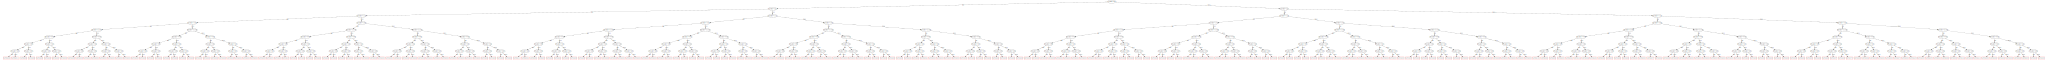

In [26]:
cb_model.plot_tree(0)

In [28]:
pred_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
dtale.show(pred_df)

In [29]:
test_catboost['demand'] = pd.Series(np.round(cb_model.predict(test_catboost[features]),0), name='y_pred').astype(int)
test_catboost['date'] = test_catboost['datetime'].dt.date
test_catboost['hour'] = test_catboost['datetime'].dt.hour

submission = test_catboost[['date', 'hour', 'demand']]

submission.to_csv(f'{DATA_DIR}/v5_catboost_msle_32_27_0.26.csv', index=False)

# ###########################
# v1: RMSE - max_depth=8
# R^2 :  0.2605607482255736
# MAE : 27.117987422351938
# RMSE: 32.8549289652779
# ###########################
# v2: MSLE - max_depth=8
# R^2 :  0.2665809910819359
# MAE : 27.058089429176192
# RMSE: 32.72090923948736
# ###########################
# v3: MSLE - max_depth=9,
# learning_rate=0.001,
# early_stopping_rounds=500
# R^2 :  0.26665031931250405
# MAE : 27.066371718803882
# RMSE: 32.71936269084083
# ###########################
# v4: MSLE - max_depth=8,
# n_estimators=50000
# learning_rate=0.0005,
# early_stopping_rounds=500
# R^2 :  0.26722209915138817
# MAE : 27.04919418596021
# RMSE: 32.70660484797922
# ###########################
# v5: MSLE - max_depth=8,
# n_estimators=50000
# learning_rate=0.0005,
# early_stopping_rounds=500
# added more features to datetime disintegrations
# R^2 :  0.27121773653411974
# MAE : 27.01415535982696
# RMSE: 32.61731287707521
# ###########################

# LSTM Encoder-Decooder

In [26]:
# from keras.models import Sequential
# from keras.layers import LSTM
# from keras.layers import Dense
# from keras.layers import RepeatVector
# from keras.layers import TimeDistributed
 
# # split a univariate sequence into samples
# def split_sequence(sequence, n_steps_in, n_steps_out):
# 	X, y = list(), list()
# 	for i in range(len(sequence)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps_in
# 		out_end_ix = end_ix + n_steps_out
# 		# check if we are beyond the sequence
# 		if out_end_ix > len(sequence):
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return np.array(X), np.array(y)
 
# # define input sequence
# raw_seq = train['demand'].to_numpy()
# # choose a number of time steps
# n_steps_in, n_steps_out = 3, 2
# # split into samples
# X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# # reshape from [samples, timesteps] into [samples, timesteps, features]
# n_features = 1
# X = X.reshape((X.shape[0], X.shape[1], n_features))
# y = y.reshape((y.shape[0], y.shape[1], n_features))
# # define model
# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
# model.add(RepeatVector(n_steps_out))
# model.add(LSTM(100, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(1)))
# model.compile(optimizer='adam', loss='mse')
# # fit model
# model.fit(X, y, epochs=100, verbose=0)
# # demonstrate prediction
# # x_input = np.array([70, 80, 90])
# # x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(X, verbose=0)
# print(yhat)